Below code for ResNet50 transfer learning with keras was inspired from the mentioned kaggle source https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50

In [113]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 
from matplotlib import pyplot

# Data Processing 
import os
import os.path
import random
import PIL
import glob
from PIL import Image # to read images
#
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


### Use Keras Model Architecture 

In [114]:
#For Keras model
import keras
from keras.models import Sequential,Model
from keras.applications import ResNet50
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import to_categorical
from keras.preprocessing import image
from keras import backend as k
import tensorflow as tf
from tensorflow.python.keras.optimizers import TFOptimizer
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

In [115]:
from sklearn.model_selection import train_test_split

In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Dataset Preparation 

In [156]:
dataset_path = './data'
anns_file_path = dataset_path + '/' + 'annotations.json'

In [157]:
path = "/content/drive/My Drive/"
annot = "/content/drive/My Drive/annotations.json"

In [158]:
# Read Annotations
with open(annot , 'r') as f:
    dataset = json.loads(f.read())

In [159]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

print(nr_images) # Total Number of images

1500


In [160]:
# category Dataframe and  Select 'six new Category(ouput classes)' for category Dataframe
cat_df = pd.DataFrame(categories)
keyValList = ['Cigarette','Clear plastic bottle','Drink can','Plastic straw','Glass bottle']
category_df = pd.DataFrame([d for d in categories if d['name'] in keyValList])

# Annotation Dataframe
ann_df = pd.DataFrame(anns)
# Images Dataframe
image_df = pd.DataFrame(imgs)

In [161]:
# Dropping unncessary columns for Keras fundamental CNN model
category_df = category_df.drop(['supercategory'], axis = 1)
image_df = image_df.drop(['license','flickr_url','coco_url','date_captured','flickr_640_url'], axis=1)
ann_df = ann_df.drop(['id'], axis=1)

In [162]:
merged_img_ann_df = pd.merge(left=image_df, right=ann_df, left_on='id', right_on='image_id')
final_merged_df = pd.merge(left=merged_img_ann_df, right=category_df, left_on='category_id', right_on='id') 
final_merged_df = final_merged_df.drop(['id_x','id_y','category_id','image_id','width','height'], axis = 1 )
final_merged_df = final_merged_df.rename(columns={"file_name": "filename", "name": "category"})
final_merged_df.head()

,filename,segmentation,area,bbox,iscrowd,category
0,batch_1/000006.jpg,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",403954.0,"[517.0, 127.0, 447.0, 1322.0]",0,Glass bottle
1,batch_1/000012.jpg,"[[481.0, 1148.0, 505.0, 1163.0, 519.0, 1172.0,...",43489.0,"[379.0, 1127.0, 425.0, 318.0]",0,Glass bottle
2,batch_1/000048.jpg,"[[586.0, 820.0, 581.0, 851.0, 579.0, 889.0, 58...",324005.0,"[211.0, 1.0, 417.0, 1417.0]",0,Glass bottle
3,batch_1/000021.jpg,"[[1001.0, 867.0, 1163.0, 905.0, 1199.0, 913.0,...",95494.5,"[852.0, 638.0, 687.0, 291.0]",0,Glass bottle
4,batch_1/000022.jpg,"[[919.0, 1125.0, 968.0, 1111.0, 1000.0, 1100.0...",142823.0,"[647.0, 1033.0, 820.0, 376.0]",0,Glass bottle


In [163]:
# New Dataframe with selective columns
df = final_merged_df[['filename','bbox','category']]

In [164]:
# storing bounding box values as seperate columns
df = pd.concat([df , df['bbox'].apply(pd.Series)], axis = 1)
df.columns = ['filename','bbox','category', 'x_min','y_min','x_max', 'y_max'] # x_max : width and y_max : height
df = df.drop(['bbox',], axis=1)

In [165]:
df.head()

,filename,category,x_min,y_min,x_max,y_max
0,batch_1/000006.jpg,Glass bottle,517.0,127.0,447.0,1322.0
1,batch_1/000012.jpg,Glass bottle,379.0,1127.0,425.0,318.0
2,batch_1/000048.jpg,Glass bottle,211.0,1.0,417.0,1417.0
3,batch_1/000021.jpg,Glass bottle,852.0,638.0,687.0,291.0
4,batch_1/000022.jpg,Glass bottle,647.0,1033.0,820.0,376.0


In [166]:
# Calculate maximum x and maximum y points
df['x_max'] = df['x_max']+df['x_min']
df['y_max'] = df['y_max']+df['y_min']
# Convert float columns to integer
for col in  df.columns[2:]:
    df[col] = df[col].astype(int)
    

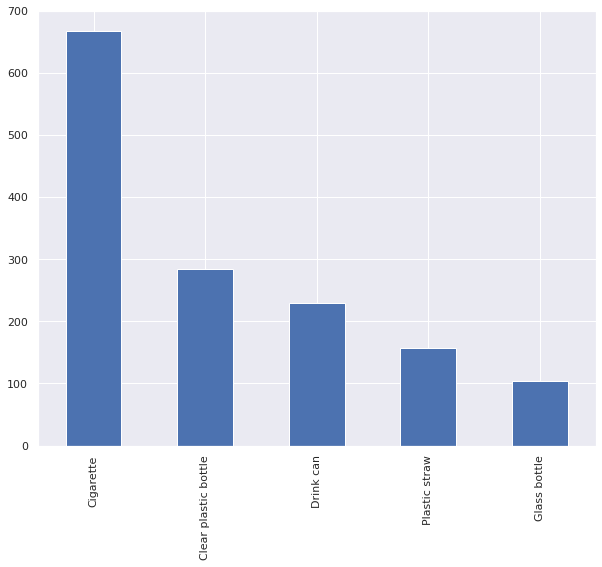

In [167]:
df['category'].value_counts().plot.bar()

### Fetch, crop and store image data

In [112]:
# path of the folder containing the original images 
inPath = path+'data' 
# path of the folder that will contain the cropped image 
outPath = path+'trainDataTACO' 
train_data = []  
for ind in df.index:
  bbox = (df['x_min'][ind],df['y_min'][ind],df['x_max'][ind],df['y_max'][ind])
  imagePath = os.path.join(inPath+'/'+df['filename'][ind])
  img = Image.open(imagePath)
  img = img.crop(bbox)
  fullOutPath = os.path.join(outPath +'/'+df['filename'][ind]) 
  img.save(fullOutPath)

KeyboardInterrupt: ignored

In [168]:
df = df.drop(['x_min','x_max','y_min','y_max'], axis=1)
df.head()

,filename,category
0,batch_1/000006.jpg,Glass bottle
1,batch_1/000012.jpg,Glass bottle
2,batch_1/000048.jpg,Glass bottle
3,batch_1/000021.jpg,Glass bottle
4,batch_1/000022.jpg,Glass bottle


In [169]:
df = df.astype({"category":'category'})

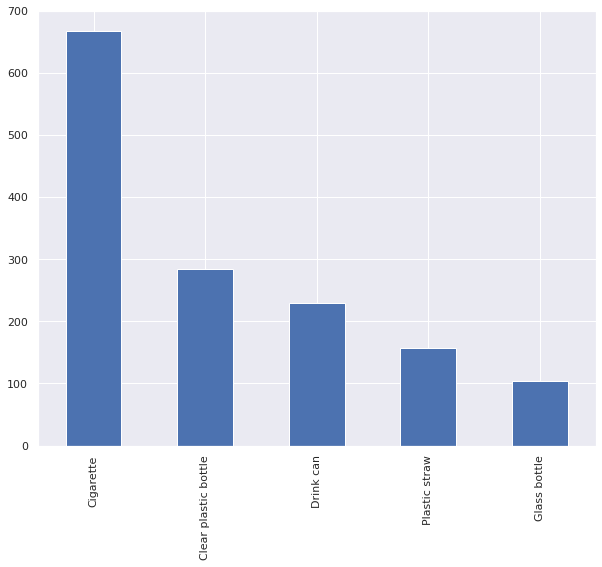

In [173]:
df['category'].value_counts().plot.bar()

### Data Split 

In [174]:
# Data split Randomly
trainData_df, testData_df = train_test_split(df, test_size=0.20, random_state=21)


In [175]:
print(trainData_df.shape)
print(testData_df.shape)

(1153, 2)
(289, 2)


#### Global Constants 

In [177]:
# Fixed for our 'Cigarette','Clear plastic bottle','Drink can','Plastic straw','Glass bottle' classes
NUM_CLASSES = 5
CHANNELS = 3

# Model parameters
IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'
input_shape = (IMAGE_RESIZE,IMAGE_RESIZE,CHANNELS)
# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 50

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 30
BATCH_SIZE_VALIDATION = 10

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1


ResNet50 Model loading

In [178]:
model = Sequential()

# First layer as the lumpsum weights from 'imagenet' which will download the latest weights for ResNet
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

# Second layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [179]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


In [180]:
from keras import optimizers

In [181]:
sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [182]:
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.10, rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

In [183]:
# Train image data generator
# Create new train folder directory which should have images
newPath = path +'trainDataTACO'
train_generator=data_generator.flow_from_dataframe(
    dataframe=trainData_df,
    directory=newPath,
    x_col="filename",
    y_col="category",
    subset="training",
    batch_size=BATCH_SIZE_TRAINING,
    seed=21,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_RESIZE,IMAGE_RESIZE)
)

Found 1038 validated image filenames belonging to 5 classes.


In [184]:
# Validation image data generator
validation_generator=data_generator.flow_from_dataframe(
    dataframe=trainData_df,
    directory=newPath,
    x_col="filename",
    y_col="category",
    subset="validation",
    batch_size=BATCH_SIZE_TRAINING,
    seed=21,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_RESIZE,IMAGE_RESIZE)
)

Found 115 validated image filenames belonging to 5 classes.


In [185]:
# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = train_generator.n//train_generator.batch_size
STEPS_PER_EPOCH_VALIDATION =  validation_generator.n//validation_generator.batch_size


In [186]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(30, 35, 10, 4)

In [187]:
filepath_model = path + '/resnet50/working/best.hdf5'
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = filepath_model, monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [188]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.load_weights(filepath_model)

Epoch 1/10
34/34 [==============================] - 24s 693ms/step - loss: 1.2474 - accuracy: 0.6042 - val_loss: 1.7694 - val_accuracy: 0.5333
Epoch 2/10
34/34 [==============================] - 20s 593ms/step - loss: 0.7670 - accuracy: 0.7550 - val_loss: 1.8498 - val_accuracy: 0.6118
Epoch 3/10
34/34 [==============================] - 20s 575ms/step - loss: 0.7676 - accuracy: 0.7510 - val_loss: 1.4622 - val_accuracy: 0.5647
Epoch 4/10
34/34 [==============================] - 19s 570ms/step - loss: 0.7184 - accuracy: 0.7775 - val_loss: 3.4061 - val_accuracy: 0.5176
Epoch 5/10
34/34 [==============================] - 20s 580ms/step - loss: 0.6837 - accuracy: 0.7781 - val_loss: 2.0286 - val_accuracy: 0.5444
Epoch 6/10
34/34 [==============================] - 20s 579ms/step - loss: 0.7062 - accuracy: 0.7679 - val_loss: 1.8033 - val_accuracy: 0.5765
Epoch 7/10
34/34 [==============================] - 19s 564ms/step - loss: 0.6366 - accuracy: 0.7788 - val_loss: 2.5803 - val_accuracy: 0.5294

In [189]:
print(fit_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


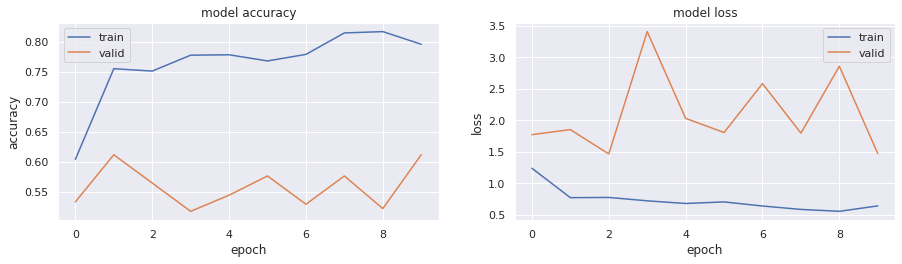

In [190]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [191]:
# test image data generator
test_generator=data_generator.flow_from_dataframe(
    dataframe=testData_df,
    directory=newPath,
    x_col="filename",
    y_col=None,
    batch_size=BATCH_SIZE_TESTING,
    seed=21,
    shuffle=False,
    class_mode=None,
    target_size=(IMAGE_RESIZE,IMAGE_RESIZE)
)

Found 289 validated image filenames.


In [192]:
# Reset before each call to predict
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

289/289 [==============================] - 10s 36ms/step


In [195]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'Cigarette',
 1: 'Clear plastic bottle',
 2: 'Drink can',
 3: 'Glass bottle',
 4: 'Plastic straw'}

In [196]:
sorting = (-pred).argsort()
# getting the top 5 predictions
sorted_ = sorting[0][:5]

In [214]:
for value in sorted_:
  predicted_label = labels[value]
  # Rounding steps
  prob = (pred[0][value]) * 100
  prob = "%.2f" % round(prob,2)
  print("Prediction is that %s%% of Data belongs to %s." % (prob, predicted_label))

Prediction is that 89.28% of Data belongs to Cigarette.
Prediction is that 6.39% of Data belongs to Plastic straw.
Prediction is that 2.97% of Data belongs to Glass bottle.
Prediction is that 0.81% of Data belongs to Drink can.
Prediction is that 0.55% of Data belongs to Clear plastic bottle.
